In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
CSV_FILE = r"C:\Users\hinat\PROJECTS\Financial_Engineering_Projects_HT\Continuously_compounded_Discount_rates_from_CouponBearing_USTreasury_Bonds\Data\US_Treasury_Data.csv"
SHEET_NAME = "Bonds"
SETTLE = pd.Timestamp("2025-02-25")   
DAYCOUNT_DENOM = 365.0                # Actual/365 used throughout
FREQ_DEFAULT = 2                      # freq of coupon payments
SAVE_PREFIX = "NS_Result"             

# 1) Load data
df = pd.read_csv(CSV_FILE, parse_dates=['Issue Date', 'Maturity'])
df = df.rename(columns=lambda s: s.strip()) # ensuring column name matching

# Compute mid price
df['MidPrice'] = (df['Bid Price'] + df['Ask Price']) / 2.0
df['CouponRate'] = df['Cpn'] / 100.0
df['Face'] = 100.0

if 'Frequency' not in df.columns:
    df['Frequency'] = FREQ_DEFAULT

In [3]:
# Helper
def generate_coupon_dates(maturity, freq=2, settle=SETTLE):
    months = int(12 // freq)
    d = pd.Timestamp(maturity)
    dates = []
    # Walk backwards from maturity to earlier dates, then keep those > settle
    for _ in range(1000):
        dates.append(d)
        d = d - relativedelta(months=months)
        if d.year < 1900:
            break
    dates = sorted(dates)
    return [pd.Timestamp(x) for x in dates if pd.Timestamp(x) > settle]

# Day-count fraction Actual/365
def year_frac(start, end):
    return (end - start).days / DAYCOUNT_DENOM

# Build coupon schedules and accrual per bond
bond_cashflows = []
for i, row in df.iterrows():
    maturity = pd.Timestamp(row['Maturity'])
    issue = pd.Timestamp(row['Issue Date'])
    freq = int(row.get('Frequency', FREQ_DEFAULT))
    coupon_rate = float(row['CouponRate'])
    coupon_amt = 100.0 * coupon_rate / freq
    coupon_dates = generate_coupon_dates(maturity, freq=freq, settle=SETTLE)
    times = [year_frac(SETTLE, d) for d in coupon_dates]

    months = int(12 // freq)
    full = []
    d = maturity
    # go backwards enough steps
    for _ in range(1000):
        full.append(pd.Timestamp(d))
        d = d - relativedelta(months=months)
        if d.year < issue.year - 5:
            break
    full = sorted(full)
    last_coupon = max([x for x in full if x <= SETTLE], default=issue)
    next_coupon = min([x for x in full if x > SETTLE], default=maturity)
    denom = year_frac(last_coupon, next_coupon) if year_frac(last_coupon, next_coupon) > 0 else 1.0
    accrual_frac = year_frac(last_coupon, SETTLE) / denom
    accrued_interest = coupon_amt * accrual_frac

    bond_cashflows.append({
        'idx': i,
        'coupon_dates': coupon_dates,
        'times': times,
        'coupon_amt': coupon_amt,
        'face': 100.0,
        'accrued_interest': accrued_interest
    })

# time range used later for plots
all_times = [t for b in bond_cashflows for t in b['times'] if t > 0]
min_t = min(all_times) if len(all_times) else 1e-3
max_t = max(all_times) if len(all_times) else 30.0

# Nelson-Siegel yield function (continuous compounding)
def ns_yield(t, params):
    # params = [beta0, beta1, beta2, tau]
    beta0, beta1, beta2, tau = params
    t = np.array(t, dtype=float)
    eps = 1e-10
    x = t / (tau + eps)
    factor = np.where(np.abs(x) < 1e-8, 1.0 - x/2.0 + x**2/12.0, (1 - np.exp(-x)) / x)
    term2 = factor
    term3 = factor - np.exp(-x)
    return beta0 + beta1 * term2 + beta2 * term3


def discount_factors_ns(t_arr, params):
    r = ns_yield(t_arr, params)
    return np.exp(-r * np.array(t_arr))

# Price single bond under NS params => returns clean and dirty prices
def fitted_price_ns(bidx, params):
    info = bond_cashflows[bidx]
    times = info['times']
    coupon = info['coupon_amt']
    face = info['face']
    if len(times) == 0:
        return 0.0, 0.0
    dfs = discount_factors_ns(times, params)
    dirty = np.sum(coupon * dfs) + face * dfs[-1]
    clean = dirty - info['accrued_interest']
    return clean, dirty

# Objective: Minimise Mean Sum of Squared Errors between fitted clean prices and market mid prices
market_prices = df['MidPrice'].values

def objective_ns(params):
    beta0, beta1, beta2, tau = params
    # enforce tau > 0 (decay positive); penalize wildly large params
    if tau <= 0 or np.any(np.abs(params) > 1e4):
        return 1e12
    msse = 0.0
    for i in range(len(df)):
        model_clean, _ = fitted_price_ns(i, params)
        msse += ((model_clean - market_prices[i])**2)/len(df)
    return msse


# Initial guess (reasonable for yields in decimal)
x0 = np.array([0.03, -0.01, 0.01, 1.0]) 
bounds = [(-1, 1), (-1, 1), (-1, 1), (1e-3, 50.0)]

print("Starting Nelson-Siegel optimization (this may take a minute)...")
res = minimize(objective_ns, x0, method='L-BFGS-B', bounds=bounds, options={'maxiter':20000})
params_ns = res.x
print("NS optimization success:", res.success, "message:", res.message)
print("NS params (beta0, beta1, beta2, tau):", params_ns)
print("NS SSE:", res.fun)

# Compute fitted prices and residuals under NS
fitted_ns = []
for i in range(len(df)):
    clean, dirty = fitted_price_ns(i, params_ns)
    fitted_ns.append(clean)
df['FittedPrice_NS'] = fitted_ns
df['Residual_NS'] = df['FittedPrice_NS'] - df['MidPrice']

# Produce cashflow-level CSV with proper Timestamps and NS implied r(t)
cf_rows = []
for i, info in enumerate(bond_cashflows):
    for j, (dt_date, t) in enumerate(zip(info['coupon_dates'], info['times'])):
        df_ns = discount_factors_ns([t], params_ns)[0]
        r_t_ns = -np.log(df_ns) / t if t > 0 else np.nan

        # Cashflow: coupon each period; final period adds face
        cf_amt = info['coupon_amt'] + info['face'] if j == len(info['times']) - 1 else info['coupon_amt']

        cf_rows.append({
            'BondIdx': i,
            'CashflowDate': pd.Timestamp(dt_date),
            't_years': t,
            'DiscountFactor_NS': df_ns,
            'r_t_NS': r_t_ns,
            'Cashflow': cf_amt,
        })

cf_ns = pd.DataFrame(cf_rows).sort_values(['BondIdx', 't_years']).reset_index(drop=True)

# Save outputs
df.to_csv(f"{SAVE_PREFIX}_bond_details.csv", index=False)
cf_ns.to_csv(f"{SAVE_PREFIX}_cashflows.csv", index=False)
print("Saved:", f"{SAVE_PREFIX}_bonds_with_NS.csv", f"{SAVE_PREFIX}_cashflows.csv")

Starting Nelson-Siegel optimization (this may take a minute)...
NS optimization success: True message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
NS params (beta0, beta1, beta2, tau): [ 0.05002728 -0.00675901 -0.01771799  2.61986335]
NS SSE: 0.095507994844115
Saved: NS_Result_bonds_with_NS.csv NS_Result_cashflows.csv


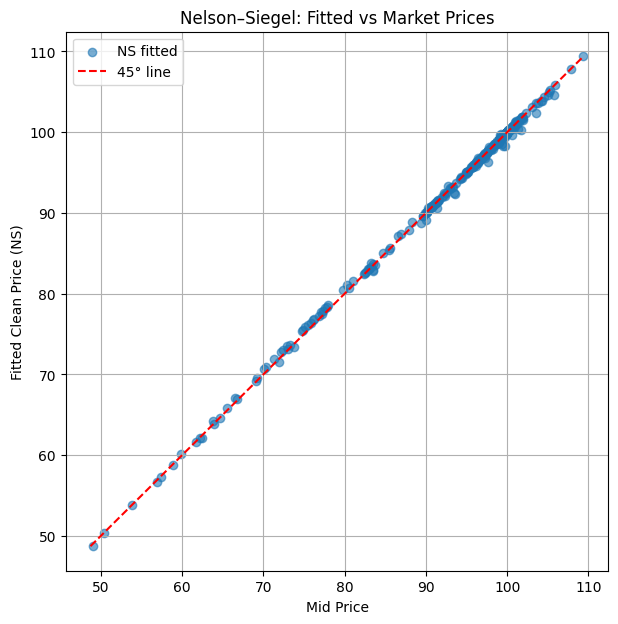

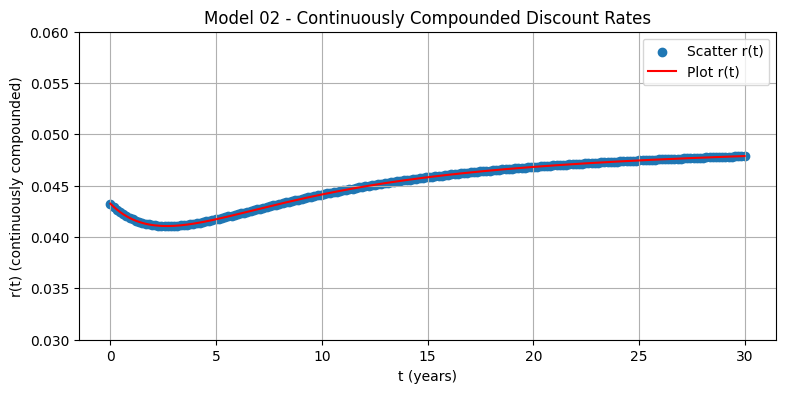

In [4]:
# Plot 1: Fitted vs Market prices (NS)
plt.figure(figsize=(7,7))
plt.scatter(df['MidPrice'], df['FittedPrice_NS'], alpha=0.6, label='NS fitted')
mn = min(df['MidPrice'].min(), df['FittedPrice_NS'].min())
mx = max(df['MidPrice'].max(), df['FittedPrice_NS'].max())
plt.plot([mn, mx], [mn, mx], 'r--', label='45° line')
plt.xlabel("Mid Price")
plt.ylabel("Fitted Clean Price (NS)")
plt.title("Nelson–Siegel: Fitted vs Market Prices")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: NS yield curve r(t)
t_grid = np.linspace(0.01, max_t, 200)
r_ns = ns_yield(t_grid, params_ns)
plt.figure(figsize=(9,4))
plt.scatter(t_grid, r_ns, label='Scatter r(t)')
plt.plot(t_grid, r_ns, '-r', label='Plot r(t)')
plt.xlabel("t (years)")
plt.ylabel("r(t) (continuously compounded)")
plt.title("Model 02 - Continuously Compounded Discount Rates")
plt.grid(True)
plt.legend()
plt.ylim(0.03, 0.06)
plt.show()

In [5]:
print("NS params (beta0, beta1, beta2, tau):", params_ns)
msse = np.mean((df['FittedPrice_NS'] -df['MidPrice'])**2)
print("msse",msse)

NS params (beta0, beta1, beta2, tau): [ 0.05002728 -0.00675901 -0.01771799  2.61986335]
msse 0.09550799484411499
